In [20]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

file_path = '/content/drive/MyDrive/Data Science Project - Sem 05 - Raleesa/Datasets/new_bin_dataset.csv'

df = pd.read_csv(file_path)
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,observation_date,fedfunds,TB3MS,TB6MS,TB1YR,USTPU,USGOOD,SRVPRD,USCONS,MANEMP,...,PCEPI,PSAVERT,PSTAX,COMREAL,COMLOAN,SECURITYBANK,PPIACO,M1SL,M2SL,recession
0,1959-07-01,3.47,3.20,3.82,4.34,10977,19529,34275,3087,15623,...,15.303,10.7,42.679,23451.0,18.3,2.1,31.7,141.7,295.2,0
1,1959-08-01,3.50,3.38,3.87,4.31,11004,19049,34287,3085,15202,...,15.325,9.6,42.679,23451.0,12.0,-32.0,31.6,141.9,296.4,0
2,1959-09-01,3.76,4.04,4.70,4.83,10991,19052,34376,3051,15254,...,15.365,8.7,42.679,23451.0,5.9,-8.8,31.7,141.0,296.7,0
3,1959-10-01,3.98,4.05,4.53,4.69,10994,18925,34433,3016,15158,...,15.402,9.4,43.733,23463.0,3.0,-13.3,31.6,140.5,296.5,0
4,1959-11-01,4.00,4.15,4.54,4.54,11014,19108,34526,3025,15300,...,15.412,10.1,43.733,23463.0,8.8,-7.8,31.5,140.4,297.1,0


In [21]:
df.columns

Index(['observation_date', 'fedfunds', 'TB3MS', 'TB6MS', 'TB1YR', 'USTPU',
       'USGOOD', 'SRVPRD', 'USCONS', 'MANEMP', 'USWTRADE', 'USTRADE', 'USINFO',
       'UNRATE', 'UNEMPLOY', 'CPIFOOD', 'CPIMEDICARE', 'CPIRENT', 'CPIAPP',
       'GDP', 'REALGDP', 'PCEPI', 'PSAVERT', 'PSTAX', 'COMREAL', 'COMLOAN',
       'SECURITYBANK', 'PPIACO', 'M1SL', 'M2SL', 'recession'],
      dtype='object')

In [22]:
import pandas as pd
import numpy as np

def create_time_series_features(df, date_col='observation_date', target_col='recession'):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).reset_index(drop=True)

    feature_cols = [col for col in df.columns if col not in [date_col, target_col]]

    print(f"Creating features for {len(feature_cols)} columns...")

    print("Creating temporal features...")
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['quarter'] = df[date_col].dt.quarter
    df['day_of_year'] = df[date_col].dt.dayofyear
    df['week_of_year'] = df[date_col].dt.isocalendar().week


    print("Creating lag features...")
    lag_periods = [1, 2, 3, 6, 12]

    lag_dfs = []

    for col in feature_cols:
        temp = pd.DataFrame({f'{col}_lag{lag}': df[col].shift(lag) for lag in lag_periods})
        lag_dfs.append(temp)

    df = pd.concat([df] + lag_dfs, axis=1)

    print("Creating rolling statistics...")
    windows = [3, 6, 12]
    for col in feature_cols:
        for window in windows:

            df[f'{col}_roll_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()

            df[f'{col}_roll_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()

            df[f'{col}_roll_min_{window}'] = df[col].rolling(window=window, min_periods=1).min()
            df[f'{col}_roll_max_{window}'] = df[col].rolling(window=window, min_periods=1).max()


    print("Creating percentage change features...")
    pct_periods = [1, 3, 6, 12]
    for col in feature_cols:
        for period in pct_periods:
            df[f'{col}_pct_change_{period}'] = df[col].pct_change(periods=period)


    print("Creating difference features...")
    for col in feature_cols:
        df[f'{col}_diff1'] = df[col].diff(1)
        df[f'{col}_diff2'] = df[col].diff(1).diff(1)

    print("Creating EMA features...")
    ema_spans = [3, 6, 12]
    for col in feature_cols:
        for span in ema_spans:
            df[f'{col}_ema_{span}'] = df[col].ewm(span=span, adjust=False).mean()

    print("Creating momentum features...")
    for col in feature_cols:
        df[f'{col}_roc_3'] = (df[col] - df[col].shift(3)) / df[col].shift(3)
        df[f'{col}_roc_12'] = (df[col] - df[col].shift(12)) / df[col].shift(12)

        df[f'{col}_momentum_3'] = df[col] - df[col].shift(3)
        df[f'{col}_momentum_12'] = df[col] - df[col].shift(12)

    print("Creating domain-specific features...")

    if all(col in df.columns for col in ['TB1YR', 'TB3MS']):
        df['yield_spread_1y_3m'] = df['TB1YR'] - df['TB3MS']

    if all(col in df.columns for col in ['TB1YR', 'TB6MS']):
        df['yield_spread_1y_6m'] = df['TB1YR'] - df['TB6MS']

    if all(col in df.columns for col in ['TB6MS', 'TB3MS']):
        df['yield_spread_6m_3m'] = df['TB6MS'] - df['TB3MS']

    if all(col in df.columns for col in ['M2SL', 'M1SL']):
        df['m2_to_m1_ratio'] = df['M2SL'] / df['M1SL']

    if all(col in df.columns for col in ['GDP', 'REALGDP']):
        df['gdp_deflator'] = df['GDP'] / df['REALGDP']

    if all(col in df.columns for col in ['UNRATE', 'GDP']):
        df['unrate_to_gdp'] = df['UNRATE'] / df['GDP']

    if all(col in df.columns for col in ['USTRADE', 'MANEMP']):
        df['trade_to_mfg_emp'] = df['USTRADE'] / df['MANEMP']

    print("Creating statistical features...")
    for col in feature_cols:

        rolling_mean = df[col].rolling(window=12, min_periods=1).mean()
        rolling_std = df[col].rolling(window=12, min_periods=1).std()
        df[f'{col}_zscore_12'] = (df[col] - rolling_mean) / (rolling_std + 1e-10)

        rolling_max = df[col].rolling(window=12, min_periods=1).max()
        rolling_min = df[col].rolling(window=12, min_periods=1).min()
        df[f'{col}_dist_from_max_12'] = df[col] - rolling_max
        df[f'{col}_dist_from_min_12'] = df[col] - rolling_min


    print("Creating interaction features...")

    if all(col in df.columns for col in ['fedfunds', 'UNRATE']):
        df['fedfunds_x_unrate'] = df['fedfunds'] * df['UNRATE']

    if all(col in df.columns for col in ['GDP_pct_change_12', 'PCEPI_pct_change_12']):
        df['gdp_growth_x_inflation'] = df['GDP_pct_change_12'] * df['PCEPI_pct_change_12']

    print(f"\nFeature engineering complete!")
    print(f"Original columns: {len(df.columns) - df.shape[1] + len(feature_cols) + 2}")
    print(f"Total columns now: {len(df.columns)}")
    print(f"New features created: {len(df.columns) - len(feature_cols) - 2}")

    return df



def remove_low_variance_features(df, threshold=0.01, exclude_cols=['observation_date', 'recession']):
    """Remove features with low variance"""
    feature_cols = [col for col in df.columns if col not in exclude_cols]

    variances = df[feature_cols].var()
    low_var_cols = variances[variances < threshold].index.tolist()

    print(f"Removing {len(low_var_cols)} low variance features (threshold={threshold})")
    return df.drop(columns=low_var_cols)


def remove_high_correlation_features(df, threshold=0.95, exclude_cols=['observation_date', 'recession']):
    """Remove highly correlated features"""
    feature_cols = [col for col in df.columns if col not in exclude_cols]

    corr_matrix = df[feature_cols].corr().abs()

    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    print(f"Removing {len(to_drop)} highly correlated features (threshold={threshold})")
    return df.drop(columns=to_drop)


def clean_feature_data(df, exclude_cols=['observation_date', 'recession']):
    feature_cols = [col for col in df.columns if col not in exclude_cols]

    df[feature_cols] = df[feature_cols].replace([np.inf, -np.inf], np.nan)
    print(f"Replaced inf/-inf values with NaN")

    nan_pct = (df[feature_cols].isna().sum() / len(df)) * 100

    cols_to_drop = nan_pct[nan_pct > 50].index.tolist()
    if cols_to_drop:
        df = df.drop(columns=cols_to_drop)
        print(f"Removed {len(cols_to_drop)} columns with >50% NaN values")


    remaining_nan = df[feature_cols].isna().sum().sum()
    print(f"Remaining NaN values: {remaining_nan}")

    feature_cols = [col for col in df.columns if col not in exclude_cols]
    df[feature_cols] = df[feature_cols].ffill().bfill()

    df[feature_cols] = df[feature_cols].fillna(0)

    print(f"Final shape: {df.shape}")
    print(f"Final NaN count: {df.isna().sum().sum()}")

    return df


def get_feature_importance(df, target_col='recession', exclude_cols=['observation_date'], n_top=50):
    """
    Get feature importance using Random Forest
    Requires: from sklearn.ensemble import RandomForestClassifier
    """
    from sklearn.ensemble import RandomForestClassifier

    feature_cols = [col for col in df.columns if col not in exclude_cols + [target_col]]

    df_clean = df.dropna()

    X = df_clean[feature_cols]
    y = df_clean[target_col]

    X = X.replace([np.inf, -np.inf], np.nan)

    mask = ~(X.isna().any(axis=1))
    X = X[mask]
    y = y[mask]

    print(f"Samples after cleaning inf/nan: {len(X)}")

    if len(X) == 0:
        raise ValueError("No valid samples remaining after removing inf/nan values")

    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X, y)

    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"\nTop {n_top} Most Important Features:")
    print(importance_df.head(n_top))

    return importance_df



df_features = create_time_series_features(df)
df_features = clean_feature_data(df_features)
df_features = remove_low_variance_features(df_features, threshold=0.01)
df_features = remove_high_correlation_features(df_features, threshold=0.95)
importance_df = get_feature_importance(df_features, target_col='recession')
top_features = importance_df.head(50)['feature'].tolist()
df_final = df_features[['observation_date', 'recession'] + top_features]

print(f"\nFinal dataset shape: {df_final.shape}")
print(f"Features selected: {len(top_features)}")


Creating features for 29 columns...
Creating temporal features...
Creating lag features...
Creating rolling statistics...


/tmp/ipython-input-3288299076.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_roll_max_{window}'] = df[col].rolling(window=window, min_periods=1).max()
/tmp/ipython-input-3288299076.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_roll_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
/tmp/ipython-input-3288299076.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joi

Creating percentage change features...


/tmp/ipython-input-3288299076.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_pct_change_{period}'] = df[col].pct_change(periods=period)
/tmp/ipython-input-3288299076.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_pct_change_{period}'] = df[col].pct_change(periods=period)
/tmp/ipython-input-3288299076.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using p

Creating difference features...
Creating EMA features...


/tmp/ipython-input-3288299076.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_diff2'] = df[col].diff(1).diff(1)
/tmp/ipython-input-3288299076.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_diff1'] = df[col].diff(1)
/tmp/ipython-input-3288299076.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Creating momentum features...


/tmp/ipython-input-3288299076.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_roc_3'] = (df[col] - df[col].shift(3)) / df[col].shift(3)
/tmp/ipython-input-3288299076.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_roc_12'] = (df[col] - df[col].shift(12)) / df[col].shift(12)
/tmp/ipython-input-3288299076.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using 

Creating domain-specific features...
Creating statistical features...


/tmp/ipython-input-3288299076.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_zscore_12'] = (df[col] - rolling_mean) / (rolling_std + 1e-10)
/tmp/ipython-input-3288299076.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_dist_from_max_12'] = df[col] - rolling_max
/tmp/ipython-input-3288299076.py:104: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(a

Creating interaction features...

Feature engineering complete!
Original columns: 31
Total columns now: 1002
New features created: 971
Replaced inf/-inf values with NaN
Remaining NaN values: 2551
Final shape: (794, 1002)
Final NaN count: 0
Removing 120 low variance features (threshold=0.01)
Removing 549 highly correlated features (threshold=0.95)
Samples after cleaning inf/nan: 794

Top 50 Most Important Features:
                       feature  importance
306   REALGDP_dist_from_min_12    0.065455
305          REALGDP_zscore_12    0.058489
272           USGOOD_zscore_12    0.052798
143        UNRATE_pct_change_6    0.050016
168               USGOOD_diff1    0.037463
291           UNRATE_zscore_12    0.033726
172               MANEMP_diff1    0.030610
219          USGOOD_momentum_3    0.028966
293    UNRATE_dist_from_min_12    0.027270
240        REALGDP_momentum_12    0.027173
230          UNRATE_momentum_3    0.025118
142        UNRATE_pct_change_3    0.023865
221          SRVPRD_mom

In [23]:
df_final.head()

,observation_date,recession,REALGDP_dist_from_min_12,REALGDP_zscore_12,USGOOD_zscore_12,UNRATE_pct_change_6,USGOOD_diff1,UNRATE_zscore_12,MANEMP_diff1,USGOOD_momentum_3,...,fedfunds_dist_from_max_12,PSAVERT,COMLOAN_roll_max_12,UNRATE_roll_std_12,USTPU_zscore_12,M1SL_roll_std_12,TB3MS_momentum_3,SECURITYBANK_roll_mean_6,MANEMP_dist_from_min_12,COMLOAN_roll_mean_3
0,1959-07-01,0,0.000,0.000000,-0.707107,0.019608,-480.0,0.707107,-421.0,-604.0,...,0.0,10.7,18.3,0.070711,0.707107,0.141421,0.85,2.10,0.0,18.300000
1,1959-08-01,0,0.000,0.000000,-0.707107,0.019608,-480.0,0.707107,-421.0,-604.0,...,0.0,9.6,18.3,0.070711,0.707107,0.141421,0.85,-14.95,0.0,15.150000
2,1959-09-01,0,0.000,0.000000,-0.571912,0.019608,3.0,1.120897,52.0,-604.0,...,0.0,8.7,18.3,0.208167,0.024686,0.472582,0.85,-12.90,52.0,12.066667
3,1959-10-01,0,9.775,1.500000,-0.801128,0.019608,-127.0,1.180194,-96.0,-604.0,...,0.0,9.4,18.3,0.275379,0.224205,0.644851,0.85,-13.00,0.0,6.966667
4,1959-11-01,0,9.775,1.095445,-0.106275,0.019608,183.0,1.114904,142.0,59.0,...,0.0,10.1,18.3,0.304959,1.290663,0.681909,0.77,-11.96,142.0,5.900000


In [24]:
df_final.columns

Index(['observation_date', 'recession', 'REALGDP_dist_from_min_12',
       'REALGDP_zscore_12', 'USGOOD_zscore_12', 'UNRATE_pct_change_6',
       'USGOOD_diff1', 'UNRATE_zscore_12', 'MANEMP_diff1', 'USGOOD_momentum_3',
       'UNRATE_dist_from_min_12', 'REALGDP_momentum_12', 'UNRATE_momentum_3',
       'UNRATE_pct_change_3', 'SRVPRD_momentum_3', 'REALGDP_momentum_3',
       'MANEMP_zscore_12', 'fedfunds_momentum_3', 'SRVPRD_zscore_12',
       'MANEMP_roll_std_3', 'USCONS_zscore_12', 'USCONS_dist_from_max_12',
       'GDP_momentum_3', 'UNRATE_roll_std_6', 'USGOOD_dist_from_min_12',
       'USINFO_diff1', 'USGOOD_roll_std_3', 'SECURITYBANK_roll_mean_12',
       'm2_to_m1_ratio', 'USGOOD_dist_from_max_12', 'USINFO_roll_std_6',
       'UNRATE_momentum_12', 'USCONS_momentum_3', 'REALGDP_roll_std_12',
       'UNRATE_diff1', 'fedfunds_diff1', 'SECURITYBANK_ema_12',
       'COMLOAN_roll_mean_12', 'USCONS_diff1', 'USCONS_dist_from_min_12',
       'TB3MS_dist_from_max_12', 'fedfunds_roll_std_12'

In [25]:
df = df_final

In [26]:
# target variables
df['recession_1m'] = df['recession'].shift(-1)   # 1 month ahead
df['recession_3m'] = df['recession'].shift(-3)   # 3 months ahead
df['recession_6m'] = df['recession'].shift(-6)   # 6 months ahead

/tmp/ipython-input-2730726798.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['recession_1m'] = df['recession'].shift(-1)   # 1 month ahead
/tmp/ipython-input-2730726798.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['recession_3m'] = df['recession'].shift(-3)   # 3 months ahead
/tmp/ipython-input-2730726798.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [27]:
df = df.dropna()

pd.set_option('display.max_rows', None)
print(df.isnull().sum())
pd.reset_option('display.max_rows')

observation_date             0
recession                    0
REALGDP_dist_from_min_12     0
REALGDP_zscore_12            0
USGOOD_zscore_12             0
UNRATE_pct_change_6          0
USGOOD_diff1                 0
UNRATE_zscore_12             0
MANEMP_diff1                 0
USGOOD_momentum_3            0
UNRATE_dist_from_min_12      0
REALGDP_momentum_12          0
UNRATE_momentum_3            0
UNRATE_pct_change_3          0
SRVPRD_momentum_3            0
REALGDP_momentum_3           0
MANEMP_zscore_12             0
fedfunds_momentum_3          0
SRVPRD_zscore_12             0
MANEMP_roll_std_3            0
USCONS_zscore_12             0
USCONS_dist_from_max_12      0
GDP_momentum_3               0
UNRATE_roll_std_6            0
USGOOD_dist_from_min_12      0
USINFO_diff1                 0
USGOOD_roll_std_3            0
SECURITYBANK_roll_mean_12    0
m2_to_m1_ratio               0
USGOOD_dist_from_max_12      0
USINFO_roll_std_6            0
UNRATE_momentum_12           0
USCONS_m

In [28]:
import wandb
wandb.login(key="26eaf8aee8b1652724751320dee2235031382a44")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [29]:
import wandb
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, average_precision_score, precision_recall_curve,
    classification_report
)
from tensorflow.keras.callbacks import Callback
import random, os
from tensorflow.keras import regularizers
from tensorflow.keras.layers import TimeDistributed
import tensorflow.keras.backend as K

# ----------------------------
# Config / W&B init
# ----------------------------
wandb.init(
    project="us-recession-transformer-lstm-hybrid",
    config={
        "seq_length": 12,
        "lstm_units": 32, #64 -> 32
        "d_model":16, #32 -> 16
        "num_heads": 2,
        "ff_dim": 32, #64
        "num_layers": 1,
        "dropout": 0.18, #0.18
        "batch_size": 32, #16
        "learning_rate": 3e-4,#5e-4
        "epochs": 150, #200
        "focal_gamma": 2.0,
        "focal_alpha": 0.9,
        "use_class_weight": True,
        "class_weight_pos": 10,   #12.0
    }
)
config = wandb.config

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# ----------------------------
# Focal loss (binary)
# ----------------------------

def focal_loss(gamma=2., alpha=0.9):
    def loss(y_true, y_pred):
        # clip to prevent log(0) issues
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        bce = - (y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred))
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        mod_factor = (1 - p_t) ** gamma
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        return K.mean(alpha_factor * mod_factor * bce)
    return loss

# ----------------------------
# Transformer building blocks
# ----------------------------
class TransformerBlock(layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super().__init__()

        key_dim = max(1, d_model // num_heads)
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.ffn = models.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(d_model),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout)
        self.dropout2 = layers.Dropout(dropout)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class PositionalEncoding(layers.Layer):
    def call(self, x, training=None):
        seq_len = tf.shape(x)[1]
        d_model = tf.shape(x)[2]
        pos = tf.cast(tf.range(seq_len)[:, tf.newaxis], tf.float32)
        i = tf.cast(tf.range(d_model)[tf.newaxis, :], tf.float32)
        angle_rates = 1 / tf.pow(10000.0, (2 * (i//2)) / tf.cast(d_model, tf.float32))
        angle_rads = pos * angle_rates
        sines = tf.sin(angle_rads[:, 0::2])
        cosines = tf.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        pos_encoding = tf.cast(pos_encoding, x.dtype)
        return x + pos_encoding



# ----------------------------
# Custom callback: compute val PR-AUC each epoch and optionally stop on no improvement
# ----------------------------
class ValPRCallback(Callback):
    def __init__(self, validation_data, patience=15, minimize=False, verbose=1):
        super().__init__()
        self.X_val, self.y_val = validation_data
        self.best = -np.inf
        self.patience = patience
        self.wait = 0
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs=None):
        y_val_prob = self.model.predict(self.X_val, verbose=0).flatten()
        pr_auc = average_precision_score(self.y_val, y_val_prob)
        logs = logs or {}
        logs['val_pr_auc'] = pr_auc
        wandb.log({"val_pr_auc": pr_auc})
        if self.verbose:
            print(f" — val_pr_auc: {pr_auc:.4f}")

        # early stopping logic on PR-AUC (maximize)
        if pr_auc > self.best + 1e-6:
            self.best = pr_auc
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"Stopping training: no improvement in val_pr_auc for {self.patience} epochs (best={self.best:.4f})")
                self.model.stop_training = True

# ----------------------------
# 3. Prepare dataset
# ----------------------------
target_col = "recession_1m"
df = df.copy()
df['observation_date'] = pd.to_datetime(df['observation_date'])

cols_to_drop = ['observation_date', 'recession', 'recession_1m', 'recession_3m', 'recession_6m']
cols_to_drop = [c for c in cols_to_drop if c in df.columns]
feature_cols = [c for c in df.columns if c not in cols_to_drop + [target_col]]

X = df[feature_cols].values
y = df[target_col].values

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ----------------------------
# 4. Sequence creation
# ----------------------------
def create_sequences(X, y, dates, seq_length):
    X_seq, y_seq, d_seq = [], [], []
    for i in range(seq_length, len(X)):
        X_seq.append(X[i-seq_length:i])
        y_seq.append(y[i])
        d_seq.append(dates[i])
    return np.array(X_seq), np.array(y_seq), np.array(d_seq)

X_seq, y_seq, d_seq = create_sequences(
    X_scaled, y, df['observation_date'].values, config.seq_length
)

# ----------------------------
# 5. Date-based split
# ----------------------------
train_end_date = "1994-01-01"
val_end_date   = "2004-01-01"

# train_end_date = "1995-01-01"
# val_end_date   = "2008-06-01"

train_mask = d_seq <= np.datetime64(train_end_date)
val_mask   = (d_seq > np.datetime64(train_end_date)) & (d_seq <= np.datetime64(val_end_date))
test_mask  = d_seq > np.datetime64(val_end_date)

X_train, y_train = X_seq[train_mask], y_seq[train_mask]
X_val, y_val     = X_seq[val_mask], y_seq[val_mask]
X_test, y_test   = X_seq[test_mask], y_seq[test_mask]

print(f"Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}")


# ----------------------------
# Build the hybrid model: LSTM -> Transformer
# ----------------------------
# Input shape: (seq_len, n_features)
n_features = X_train.shape[2]
seq_len = X_train.shape[1]

inputs = layers.Input(shape=(seq_len, n_features))

# optional small projection to help LSTM (you can remove if not needed)
x = layers.Dense(config.d_model, activation=None)(inputs)

# # LSTM encoder (return sequences) -------------------------------------------------------------
x = layers.LSTM(config.lstm_units, return_sequences=True)(x)

x = layers.Dropout(config.dropout)(x)
#x = layers.SpatialDropout1D(config.dropout)(x)
#x = layers.LayerNormalization(epsilon=1e-6)(x) #-----------------------------------------------

# project LSTM outputs to d_model for transformer residual consistency ----------------------------
x = layers.Dense(config.d_model)(x)

# add positional encoding and transformer blocks
x = PositionalEncoding()(x)
# x = PositionalEncoding(seq_len, config.d_model)(x)

for _ in range(config.num_layers):
    x = TransformerBlock(config.d_model, config.num_heads, config.ff_dim, config.dropout)(x)

# Pooling + classifier
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(config.dropout)(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=config.learning_rate),
    loss=focal_loss(gamma=config.focal_gamma, alpha=config.focal_alpha),
    metrics=["accuracy"]
)

model.summary()

# ----------------------------
# Fit: callbacks & class weights
# ----------------------------
val_pr_cb = ValPRCallback(validation_data=(X_val, y_val), patience=20)

if config.use_class_weight:
    class_weight = {0: 1.0, 1: float(config.class_weight_pos)}
else:
    class_weight = None

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=config.epochs,
    batch_size=config.batch_size,
    shuffle=False,
    callbacks=[val_pr_cb]
    #callbacks=[val_pr_cb, wandb.keras.WandbCallback(save_graph=False, save_model=False)]
    ,
    class_weight=class_weight
)


# ----------------------------
# Threshold selection (validation only)
# ----------------------------
chosen_thresh = 0.3 #0.71
# chosen_thresh = best_f1_thresh
#chosen_thresh = best_j_thresh


# ----------------------------
# Evaluate on test
# ----------------------------
y_test_prob = model.predict(X_test).flatten()
y_pred = (y_test_prob >= chosen_thresh).astype(int)

acc = accuracy_score(y_test, y_pred)
prec_score_val = precision_score(y_test, y_pred, zero_division=0)
rec_score = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_test_prob)
pr_auc = average_precision_score(y_test, y_test_prob)

print("\nHybrid LSTM + Transformer Model Results - 1m recession")
print(f"Accuracy   : {acc:.4f}")
print(f"Precision  : {prec_score_val:.4f}")
print(f"Recall     : {rec_score:.4f}")
print(f"F1 Score   : {f1:.4f}")
print(f"ROC-AUC    : {roc_auc:.4f}")
print(f"PR-AUC     : {pr_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Log final numbers to W&B
# wandb.summary["chosen_threshold"] = float(chosen_thresh)
# wandb.summary["best_f1_threshold"] = float(best_f1_thresh)
# wandb.summary["recall_first_threshold"] = float(recall_first_thresh)
wandb.summary["test_accuracy"] = acc
wandb.summary["f1_score"] = f1
wandb.summary["precision"] = prec_score_val
wandb.summary["recall"] = rec_score
wandb.summary["roc_auc"] = roc_auc
wandb.summary["pr_auc"] = pr_auc


val_pr_auc,▁▁▁▂▂▂▂▃▃▄▆▇▇███████████████████▇▇▇▇▇▇▇
f1_score,0.34615
pr_auc,0.83987
precision,0.21429
recall,0.9
roc_auc,0.94335
test_accuracy,0.73123
val_pr_auc,0.83631


Train size: 403, Val size: 120, Test size: 253


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 12, 16)         │           816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 12, 32)         │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 12, 16)         │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding_2           │ (None, 12, 16)         │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 12, 16)         │         2,224 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,417 (40.69 KB)

 Trainable params: 10,417 (40.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2964 - loss: 0.1228 — val_pr_auc: 0.0817
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.2976 - loss: 0.1236 - val_accuracy: 0.0667 - val_loss: 0.0377 - val_pr_auc: 0.0817
Epoch 2/150
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2765 - loss: 0.1052 — val_pr_auc: 0.1058
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2756 - loss: 0.1064 - val_accuracy: 0.0667 - val_loss: 0.0417 - val_pr_auc: 0.1058
Epoch 3/150
 9/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1851 - loss: 0.1005 — val_pr_auc: 0.1350
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2026 - loss: 0.1030 - val_accuracy: 0.0667 - val_loss: 0.0413 - val_pr_auc: 0.1350
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2150 - loss: 0.0977 — val_pr_auc: 0.1594
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2174 - loss: 0.0979 - val_accuracy: 0.0667 - val_loss: 0.0383 - val_pr_auc: 0.1594
Epoch 5/150
 9/13 ━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
THRESHOLD OPTIMIZATION ANALYSIS

                threshold  precision  recall        f1
F1-Optimal       0.656232   0.857143   0.750  0.800000
Youden-J         0.414571   0.500000   1.000  0.666667
Recall-90%       0.517842   0.700000   0.875  0.777778
Precision-70%    0.517842   0.700000   0.875  0.777778
Cost-Sensitive   0.392392   0.500000   1.000  0.666667
Plot saved to threshold_analysis.png


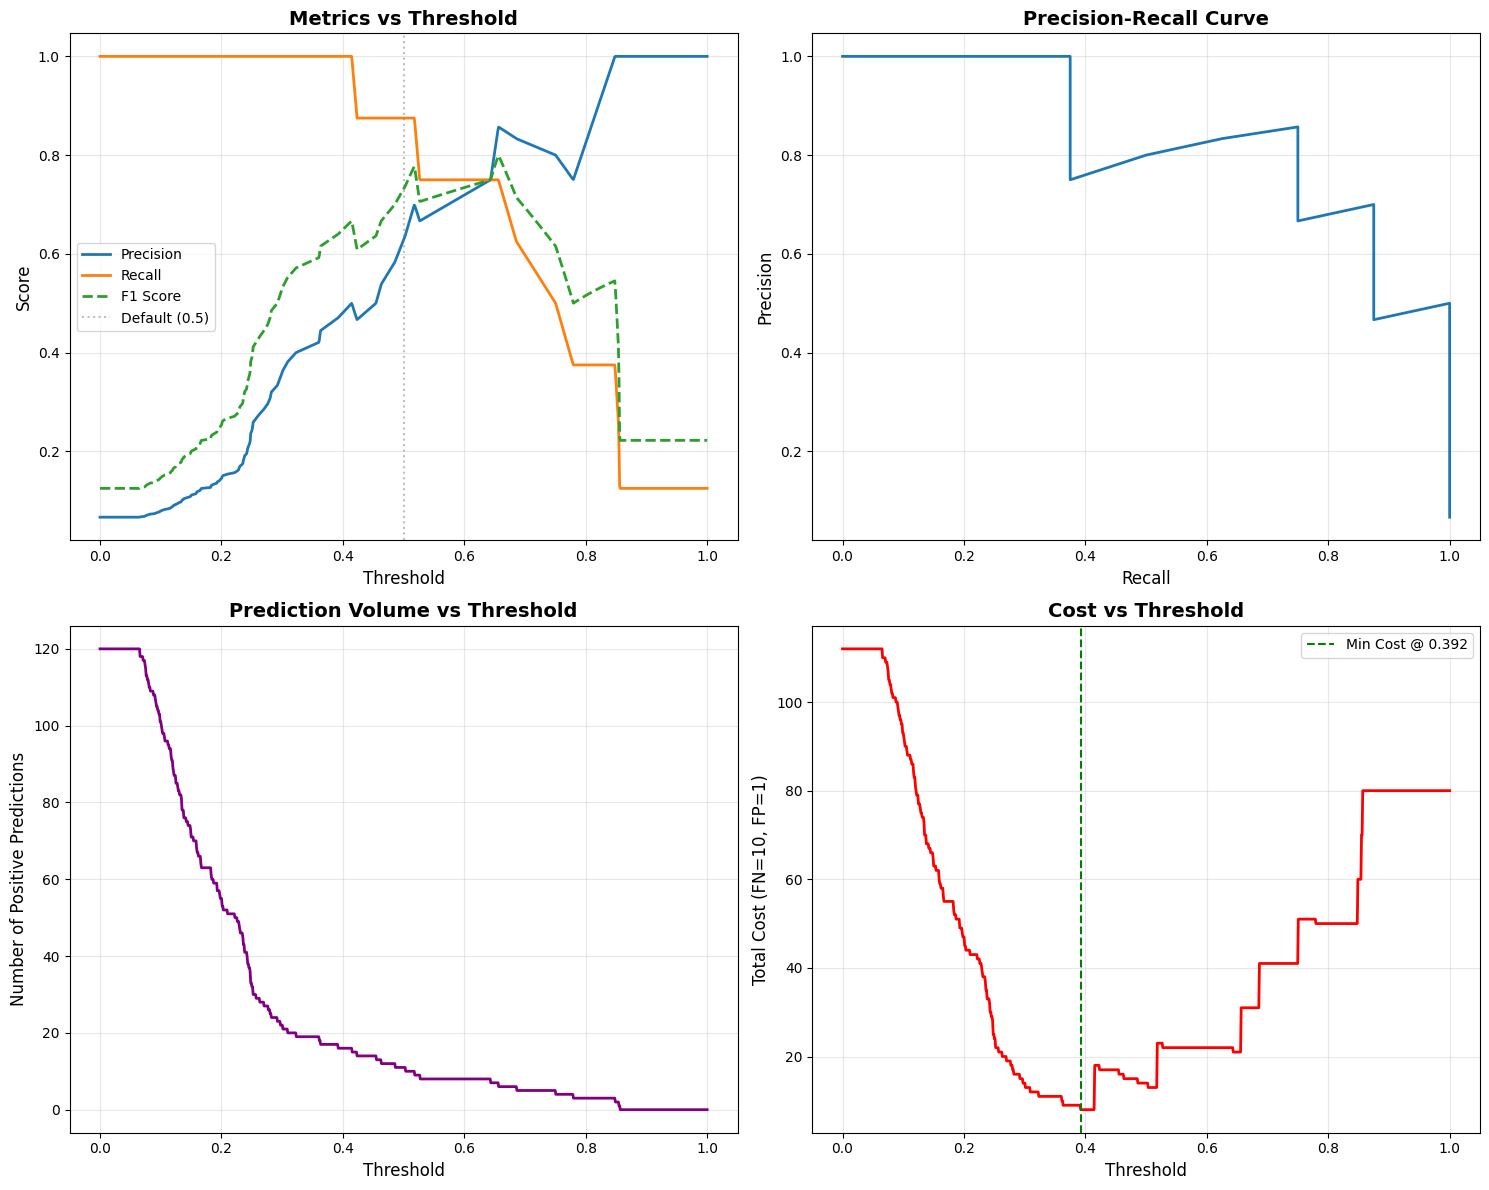


Chosen threshold: 0.4146
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step

Hybrid LSTM + Transformer Model Results - 1m recession
Accuracy   : 0.7312
Precision  : 0.2143
Recall     : 0.9000
F1 Score   : 0.3462
ROC-AUC    : 0.9433
PR-AUC     : 0.8399

              precision    recall  f1-score   support

         0.0     0.9898    0.8326    0.9044       233
         1.0     0.3158    0.9000    0.4675        20

    accuracy                         0.8379       253
   macro avg     0.6528    0.8663    0.6860       253
weighted avg     0.9365    0.8379    0.8699       253



In [31]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    precision_recall_curve, roc_curve, confusion_matrix
)
import matplotlib.pyplot as plt


def optimize_threshold_f1(y_true, y_prob):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else thresholds[-1]
    best_f1 = f1_scores[best_idx]

    return best_threshold, best_f1


def optimize_threshold_youden(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    j_scores = tpr - fpr  # Youden's J statistic

    best_idx = np.argmax(j_scores)
    best_threshold = thresholds[best_idx]
    best_j = j_scores[best_idx]

    return best_threshold, best_j


def optimize_threshold_recall_target(y_true, y_prob, target_recall=0.90, tolerance=0.05):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)

    # Find thresholds that meet recall target (within tolerance)
    valid_mask = (recalls >= target_recall - tolerance) & (recalls <= 1.0)

    if not valid_mask.any():
        # If no threshold meets target, return threshold with highest recall
        best_idx = np.argmax(recalls)
        best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
        print(f"Warning: Could not achieve target recall {target_recall:.2f}")
        return best_threshold, recalls[best_idx]

    # Among valid thresholds, find the one with highest precision
    valid_precisions = precisions[valid_mask]
    valid_thresholds_idx = np.where(valid_mask)[0]

    best_valid_idx = np.argmax(valid_precisions)
    best_idx = valid_thresholds_idx[best_valid_idx]
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5

    return best_threshold, recalls[best_idx]


def optimize_threshold_precision_target(y_true, y_prob, target_precision=0.70, tolerance=0.05):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)

    # Find thresholds that meet precision target
    valid_mask = (precisions >= target_precision - tolerance) & (precisions <= 1.0)

    if not valid_mask.any():
        print(f"Warning: Could not achieve target precision {target_precision:.2f}")
        best_idx = np.argmax(precisions)
        best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
        return best_threshold, precisions[best_idx]

    # Among valid thresholds, find the one with highest recall
    valid_recalls = recalls[valid_mask]
    valid_thresholds_idx = np.where(valid_mask)[0]

    best_valid_idx = np.argmax(valid_recalls)
    best_idx = valid_thresholds_idx[best_valid_idx]
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5

    return best_threshold, precisions[best_idx]


def optimize_threshold_cost_sensitive(y_true, y_prob, fn_cost=10, fp_cost=1):
    thresholds = np.linspace(0, 1, 1000)
    costs = []

    for thresh in thresholds:
        y_pred = (y_prob >= thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        cost = fn * fn_cost + fp * fp_cost
        costs.append(cost)

    best_idx = np.argmin(costs)
    best_threshold = thresholds[best_idx]

    return best_threshold, costs[best_idx]



def analyze_all_thresholds(y_true, y_prob):
    print("=" * 80)
    print("THRESHOLD OPTIMIZATION ANALYSIS")
    print("=" * 80)

    results = {}

    # 1. F1-optimal
    thresh_f1, best_f1 = optimize_threshold_f1(y_true, y_prob)
    y_pred_f1 = (y_prob >= thresh_f1).astype(int)
    results['F1-Optimal'] = {
        'threshold': thresh_f1,
        'precision': precision_score(y_true, y_pred_f1, zero_division=0),
        'recall': recall_score(y_true, y_pred_f1, zero_division=0),
        'f1': f1_score(y_true, y_pred_f1, zero_division=0)
    }

    # 2. Youden's J
    thresh_j, best_j = optimize_threshold_youden(y_true, y_prob)
    y_pred_j = (y_prob >= thresh_j).astype(int)
    results['Youden-J'] = {
        'threshold': thresh_j,
        'precision': precision_score(y_true, y_pred_j, zero_division=0),
        'recall': recall_score(y_true, y_pred_j, zero_division=0),
        'f1': f1_score(y_true, y_pred_j, zero_division=0)
    }

    # 3. Recall-targeted (90%)
    thresh_rec, achieved_rec = optimize_threshold_recall_target(y_true, y_prob, target_recall=0.90)
    y_pred_rec = (y_prob >= thresh_rec).astype(int)
    results['Recall-90%'] = {
        'threshold': thresh_rec,
        'precision': precision_score(y_true, y_pred_rec, zero_division=0),
        'recall': recall_score(y_true, y_pred_rec, zero_division=0),
        'f1': f1_score(y_true, y_pred_rec, zero_division=0)
    }

    # 4. Precision-targeted (70%)
    thresh_prec, achieved_prec = optimize_threshold_precision_target(y_true, y_prob, target_precision=0.70)
    y_pred_prec = (y_prob >= thresh_prec).astype(int)
    results['Precision-70%'] = {
        'threshold': thresh_prec,
        'precision': precision_score(y_true, y_pred_prec, zero_division=0),
        'recall': recall_score(y_true, y_pred_prec, zero_division=0),
        'f1': f1_score(y_true, y_pred_prec, zero_division=0)
    }

    # 5. Cost-sensitive (missing recession is 10x worse)
    thresh_cost, min_cost = optimize_threshold_cost_sensitive(y_true, y_prob, fn_cost=10, fp_cost=1)
    y_pred_cost = (y_prob >= thresh_cost).astype(int)
    results['Cost-Sensitive'] = {
        'threshold': thresh_cost,
        'precision': precision_score(y_true, y_pred_cost, zero_division=0),
        'recall': recall_score(y_true, y_pred_cost, zero_division=0),
        'f1': f1_score(y_true, y_pred_cost, zero_division=0)
    }

    # Print results
    df_results = pd.DataFrame(results).T
    print("\n" + df_results.to_string())
    print("=" * 80)

    return results, df_results


def plot_threshold_analysis(y_true, y_prob, save_path=None):
    precisions, recalls, pr_thresholds = precision_recall_curve(y_true, y_prob)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

    # Align threshold arrays (precision_recall_curve returns n-1 thresholds)
    thresholds = np.linspace(0, 1, 1000)
    precision_interp = np.interp(thresholds, pr_thresholds, precisions[:-1])
    recall_interp = np.interp(thresholds, pr_thresholds, recalls[:-1])
    f1_interp = 2 * (precision_interp * recall_interp) / (precision_interp + recall_interp + 1e-10)

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: Precision, Recall, F1 vs Threshold
    ax1 = axes[0, 0]
    ax1.plot(thresholds, precision_interp, label='Precision', linewidth=2)
    ax1.plot(thresholds, recall_interp, label='Recall', linewidth=2)
    ax1.plot(thresholds, f1_interp, label='F1 Score', linewidth=2, linestyle='--')
    ax1.axvline(0.5, color='gray', linestyle=':', alpha=0.5, label='Default (0.5)')
    ax1.set_xlabel('Threshold', fontsize=12)
    ax1.set_ylabel('Score', fontsize=12)
    ax1.set_title('Metrics vs Threshold', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Precision-Recall Curve
    ax2 = axes[0, 1]
    ax2.plot(recalls, precisions, linewidth=2)
    ax2.set_xlabel('Recall', fontsize=12)
    ax2.set_ylabel('Precision', fontsize=12)
    ax2.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)

    # Plot 3: Number of predictions vs Threshold
    ax3 = axes[1, 0]
    predictions_count = [np.sum(y_prob >= t) for t in thresholds]
    ax3.plot(thresholds, predictions_count, linewidth=2, color='purple')
    ax3.set_xlabel('Threshold', fontsize=12)
    ax3.set_ylabel('Number of Positive Predictions', fontsize=12)
    ax3.set_title('Prediction Volume vs Threshold', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)

    # Plot 4: Cost vs Threshold (FN cost = 10, FP cost = 1)
    ax4 = axes[1, 1]
    costs = []
    fn_cost, fp_cost = 10, 1
    for thresh in thresholds:
        y_pred = (y_prob >= thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        cost = fn * fn_cost + fp * fp_cost
        costs.append(cost)

    ax4.plot(thresholds, costs, linewidth=2, color='red')
    ax4.axvline(thresholds[np.argmin(costs)], color='green', linestyle='--',
                label=f'Min Cost @ {thresholds[np.argmin(costs)]:.3f}')
    ax4.set_xlabel('Threshold', fontsize=12)
    ax4.set_ylabel(f'Total Cost (FN={fn_cost}, FP={fp_cost})', fontsize=12)
    ax4.set_title('Cost vs Threshold', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()



y_val_prob = model.predict(X_val).flatten()
results, df_results = analyze_all_thresholds(y_val, y_val_prob)
plot_threshold_analysis(y_val, y_val_prob, save_path='threshold_analysis.png')
best_threshold = results['F1-Optimal']['threshold']
best_threshold = results['Recall-90%']['threshold']
best_threshold = results['Cost-Sensitive']['threshold']
best_threshold, _ = optimize_threshold_recall_target(y_val, y_val_prob, target_recall=0.95)

print(f"\nChosen threshold: {best_threshold:.4f}")
y_test_prob = model.predict(X_test).flatten()
y_test_pred = (y_test_prob >= best_threshold).astype(int)

from sklearn.metrics import classification_report

print("\nHybrid LSTM + Transformer Model Results - 1m recession")
print(f"Accuracy   : {acc:.4f}")
print(f"Precision  : {prec_score_val:.4f}")
print(f"Recall     : {rec_score:.4f}")
print(f"F1 Score   : {f1:.4f}")
print(f"ROC-AUC    : {roc_auc:.4f}")
print(f"PR-AUC     : {pr_auc:.4f}")
print()
print(classification_report(y_test, y_test_pred, digits=4))



13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


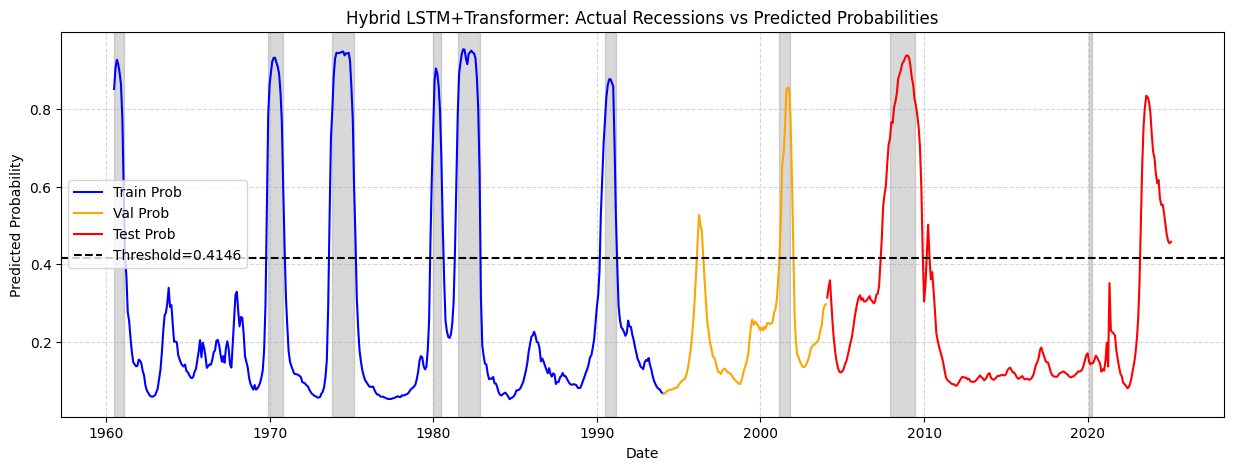

In [32]:
import matplotlib.pyplot as plt

# ----------------------------
# 1. Convert split dates to pandas datetime
# ----------------------------
train_dates = pd.to_datetime(d_seq[train_mask])
val_dates   = pd.to_datetime(d_seq[val_mask])
test_dates  = pd.to_datetime(d_seq[test_mask])

# ----------------------------
# 2. Predictions for each split
# ----------------------------
chosen_thresh = best_threshold
# Train
preds_prob_train = pd.Series(model.predict(X_train).flatten(), index=train_dates)
preds_class_train = (preds_prob_train >= chosen_thresh).astype(int)
actuals_train = pd.Series(y_train, index=train_dates)

# Validation
preds_prob_val = pd.Series(model.predict(X_val).flatten(), index=val_dates)
preds_class_val = (preds_prob_val >= chosen_thresh).astype(int)
actuals_val = pd.Series(y_val, index=val_dates)

# Test
preds_prob_test = pd.Series(y_test_prob, index=test_dates)   # from evaluation step
preds_class_test = pd.Series(y_pred, index=test_dates)       # already thresholded
actuals_test = pd.Series(y_test, index=test_dates)

# ----------------------------
# 3. Combined probability plot
# ----------------------------
plt.figure(figsize=(15, 5))

# Shade recession periods (based on actual labels across all splits)
all_actuals = pd.concat([actuals_train, actuals_val, actuals_test])
in_recession = False
start_date = None
for date, value in all_actuals.items():
    if value == 1 and not in_recession:
        start_date = date
        in_recession = True
    elif value == 0 and in_recession:
        plt.axvspan(start_date, date, color='gray', alpha=0.3)
        in_recession = False
if in_recession:
    plt.axvspan(start_date, all_actuals.index[-1], color='gray', alpha=0.3)

# Plot predicted probabilities
plt.plot(preds_prob_train.index, preds_prob_train, color='blue', label='Train Prob')
plt.plot(preds_prob_val.index, preds_prob_val, color='orange', label='Val Prob')
plt.plot(preds_prob_test.index, preds_prob_test, color='red', label='Test Prob')

# Add threshold line
plt.axhline(y=chosen_thresh, color='black', linestyle='--', label=f'Threshold={chosen_thresh:.4f}')

plt.title("Hybrid LSTM+Transformer: Actual Recessions vs Predicted Probabilities")
plt.xlabel("Date")
plt.ylabel("Predicted Probability")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# ----------------------------
# 4. Example: validation table
# ----------------------------
table_val = pd.DataFrame({
    "Date": actuals_val.index,
    "Actual": actuals_val.values,
    "Predicted": preds_class_val.values,
    "Pred_Prob": preds_prob_val.values
})

#display(table_val.head(20))


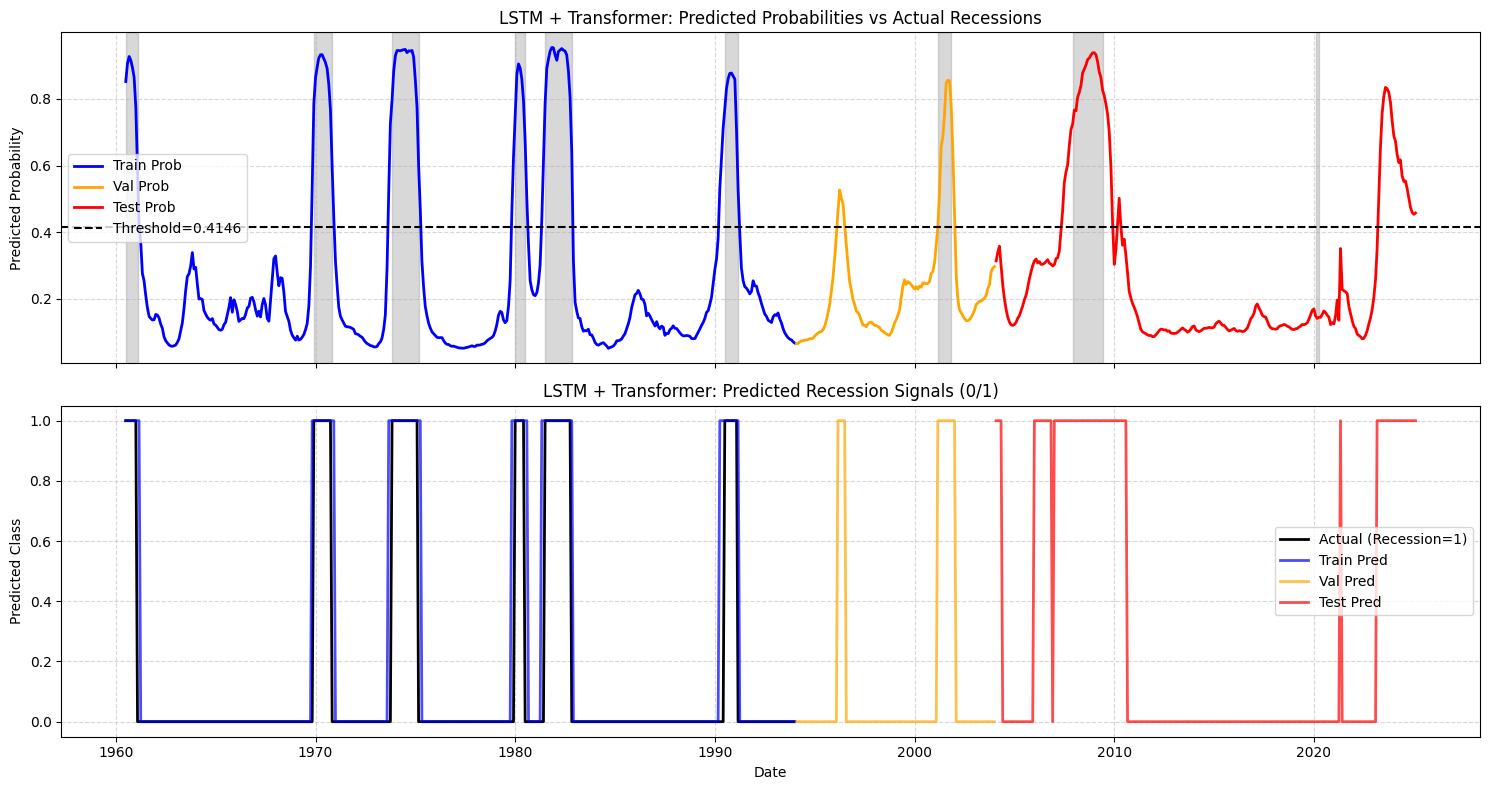

In [33]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# ----------------------------
# Subplot 1: Predicted Probabilities
# ----------------------------
axes[0].plot(preds_prob_train.index, preds_prob_train, color='blue', label='Train Prob', linewidth=2)
axes[0].plot(preds_prob_val.index, preds_prob_val, color='orange', label='Val Prob', linewidth=2)
axes[0].plot(preds_prob_test.index, preds_prob_test, color='red', label='Test Prob', linewidth=2)

# Shade recession periods from actual labels
all_actuals = pd.concat([actuals_train, actuals_val, actuals_test])
in_recession = False
start_date = None
for date, value in all_actuals.items():
    if value == 1 and not in_recession:
        start_date = date
        in_recession = True
    elif value == 0 and in_recession:
        axes[0].axvspan(start_date, date, color='gray', alpha=0.3)
        in_recession = False
if in_recession:
    axes[0].axvspan(start_date, all_actuals.index[-1], color='gray', alpha=0.3)

# Add threshold line
axes[0].axhline(y=chosen_thresh, color='black', linestyle='--', linewidth=1.5,
                label=f'Threshold={chosen_thresh:.4f}')

axes[0].set_title("LSTM + Transformer: Predicted Probabilities vs Actual Recessions")
axes[0].set_ylabel("Predicted Probability")
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.5)

# ----------------------------
# Subplot 2: Predicted Classes
# ----------------------------
axes[1].plot(actuals_train.index, actuals_train, color='black',
             label='Actual (Recession=1)', linewidth=2)
axes[1].plot(preds_class_train.index, preds_class_train, color='blue',
             alpha=0.7, label='Train Pred', linewidth=2)
axes[1].plot(preds_class_val.index, preds_class_val, color='orange',
             alpha=0.7, label='Val Pred', linewidth=2)
axes[1].plot(preds_class_test.index, preds_class_test, color='red',
             alpha=0.7, label='Test Pred', linewidth=2)

axes[1].set_title("LSTM + Transformer: Predicted Recession Signals (0/1)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Predicted Class")
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
